# Load Test deployed web application

This notebook pulls some images and tests them against the deployed web application. We submit requests asychronously which should reduce the contribution of latency.

In [1]:
import asyncio
import json
import random
import urllib.request
from timeit import default_timer

import aiohttp
import matplotlib.pyplot as plt
import testing_utilities
from tqdm import tqdm
import requests

%matplotlib inline

In [2]:
print(aiohttp.__version__)  # 3.1.1

3.1.1


We will test our deployed service with 100 calls. We will only have 4 requests concurrently at any time. We have only deployed one pod on one node and increasing the number of concurrent calls does not really increase throughput. Feel free to try different values and see how the service responds.

In [3]:
NUMBER_OF_REQUESTS = 100  # Total number of requests
CONCURRENT_REQUESTS = 4   # Number of requests at a time

Get the IP address of our service.

In [4]:
service_json = !kubectl get service azure-dl -o json
service_dict = json.loads(''.join(service_json))
app_url = service_dict['status']['loadBalancer']['ingress'][0]['ip']

In [5]:
scoring_url = 'http://{}/score'.format(app_url)
version_url = 'http://{}/version'.format(app_url)

In [6]:
!curl $version_url # Reports the Tensorflow Version

1.4.1

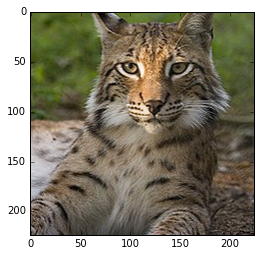

In [7]:
IMAGEURL = "https://upload.wikimedia.org/wikipedia/commons/thumb/6/68/Lynx_lynx_poing.jpg/220px-Lynx_lynx_poing.jpg"
plt.imshow(testing_utilities.to_img(IMAGEURL))

In [8]:
def gen_variations_of_one_image(num):
    out_images = []
    img = testing_utilities.to_img(IMAGEURL).convert('RGB')
    img_url_name = IMAGEURL.split('/')[-1]
    # Flip the colours for one-pixel
    # "Different Image"
    for i in range(num):
        diff_img = img.copy()
        rndm_pixel_x_y = (random.randint(0, diff_img.size[0]-1), 
                          random.randint(0, diff_img.size[1]-1))
        current_color = diff_img.getpixel(rndm_pixel_x_y)
        diff_img.putpixel(rndm_pixel_x_y, current_color[::-1])
        b64img = testing_utilities.to_base64(diff_img)
        img_dict = {img_url_name: b64img}
        body = json.dumps(img_dict)
        out_images.append(json.dumps({'input':'{}'.format(body)}))
    return out_images

In [13]:
url_list = [[scoring_url, jsonimg] for jsonimg in gen_variations_of_one_image(NUMBER_OF_REQUESTS)]

In [14]:
def decode(result):
    return json.loads(result.decode("utf-8"))

In [15]:
async def fetch(url, session, data, headers):
    start_time = default_timer()
    async with session.request('post', url, data=data, headers=headers) as response:
        resp = await response.read()
        elapsed = default_timer() - start_time
        return resp, elapsed

In [16]:
async def bound_fetch(sem, url, session, data, headers):
    # Getter function with semaphore.
    async with sem:
        return await fetch(url, session, data, headers)

In [17]:
async def await_with_progress(coros):
    results=[]
    for f in tqdm(asyncio.as_completed(coros), total=len(coros)):
        result = await f
        results.append((decode(result[0]),result[1]))
    return results

In [18]:
async def run(url_list, num_concurrent=CONCURRENT_REQUESTS):
    headers = {'content-type': 'application/json'}
    tasks = []
    # create instance of Semaphore
    sem = asyncio.Semaphore(num_concurrent)

    # Create client session that will ensure we dont open new connection
    # per each request.
    async with aiohttp.ClientSession() as session:
        for url, data in url_list:
            # pass Semaphore and session to every POST request
            task = asyncio.ensure_future(bound_fetch(sem, url, session, data, headers))
            tasks.append(task)
        return await await_with_progress(tasks)

Below we run the 100 requests against our deployed service.

In [19]:
loop = asyncio.get_event_loop()
start_time = default_timer()
complete_responses = loop.run_until_complete(asyncio.ensure_future(run(url_list, num_concurrent=CONCURRENT_REQUESTS)))
elapsed = default_timer() - start_time
print('Total Elapsed {}'.format(elapsed))
print('Avg time taken {0:4.2f} ms'.format(1000*elapsed/len(url_list)))

100%|██████████| 100/100 [00:08<00:00, 11.44it/s]

Total Elapsed 8.752600479871035
Avg time taken 87.53 ms


In [20]:
complete_responses[:3]

[({'result': "([{'220px-Lynx_lynx_poing.jpg': [('n02127052', 'lynx', 0.9816016), ('n02128385', 'leopard', 0.0077948296), ('n02123159', 'tiger_cat', 0.0036774687)]}], 'Predictions took 119.34 ms')"},
  0.292483801022172),
 ({'result': "([{'220px-Lynx_lynx_poing.jpg': [('n02127052', 'lynx', 0.98163605), ('n02128385', 'leopard', 0.0077474415), ('n02123159', 'tiger_cat', 0.0036894928)]}], 'Predictions took 117.69 ms')"},
  0.41121730767190456),
 ({'result': "([{'220px-Lynx_lynx_poing.jpg': [('n02127052', 'lynx', 0.9815933), ('n02128385', 'leopard', 0.007776721), ('n02123159', 'tiger_cat', 0.0036884877)]}], 'Predictions took 110.04 ms')"},
  0.5234297635033727)]

In [45]:
num_succesful=[eval(i[0]['result'])[0][0]['220px-Lynx_lynx_poing.jpg'][0][0] for i in complete_responses].count('n02127052')
print('Succesful {} out of {}'.format(num_succesful, len(url_list)))

Succesful 100 out of 100


({'result': "([{'220px-Lynx_lynx_poing.jpg': [('n02127052', 'lynx', 0.9816016), ('n02128385', 'leopard', 0.0077948296), ('n02123159', 'tiger_cat', 0.0036774687)]}], 'Predictions took 119.34 ms')"},
 0.292483801022172)

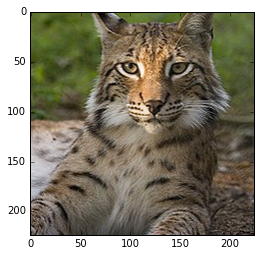

In [46]:
# Example response
plt.imshow(testing_utilities.to_img(IMAGEURL))
complete_responses[0]